# Normal model for basketball scores

In [ ]:
import pandas as pd, numpy as np, scipy as sp, matplotlib.pyplot as plt, pymc3 as pm
from scipy import stats
from sklearn.preprocessing import StandardScaler
import plot_tools

In [ ]:
bball = pd.read_csv('data/basketball.csv')
bball.head()
modern = bball[bball['Year'] > 1960]

## Unknown variance

For this, to improve the interestingness of visualizations, I take several subsamples so we can get some less precise estimates.

In [ ]:
bball.plot('Year', 'Combined', kind = 'scatter')
plt.title('Combined score vs. time')
plt.savefig('scorevtime.png')

In [ ]:
# Get some subsamples
modern_era = bball[bball['Year']>1987]
sample_small = modern_era.iloc[np.random.choice(len(modern_era), 10)]    # 10 games
sample_med = modern_era.iloc[np.random.choice(len(modern_era), 40)]    # 40 games
sample_large = modern_era.iloc[np.random.choice(len(modern_era), 100)]    # 100 games

mean_small = sample_small['Combined'].mean()
mean_med = sample_med['Combined'].mean()
mean_large = sample_large['Combined'].mean()

sd_small = sample_small['Combined'].std()
sd_med = sample_small['Combined'].std()
sd_large = sample_small['Combined'].std()

In [ ]:
# scipy doesn't have the scaled inverse-chi-squared distribution, so we do the scale and inverse part ourselves
def get_sigma2(sd, n):
    x = sp.stats.chi2.rvs(n-1)
    y = 1/x
    sigma2 = y * (n-1) * sd**2
    return sigma2

# this is just a normal
def get_mu(ybar, sigma, n):
    return sp.stats.norm.rvs(ybar, sigma / np.sqrt(n))

In [ ]:
def sample_posterior(ybar, sd, n):
    sigma2 = get_sigma2(sd, n)
    mu = get_mu(ybar, sigma2 ** (1/2), n)
    return (mu, sigma2)

In [ ]:
sample_small

In [ ]:
sample_posterior(mean_large, sd_large, 100)

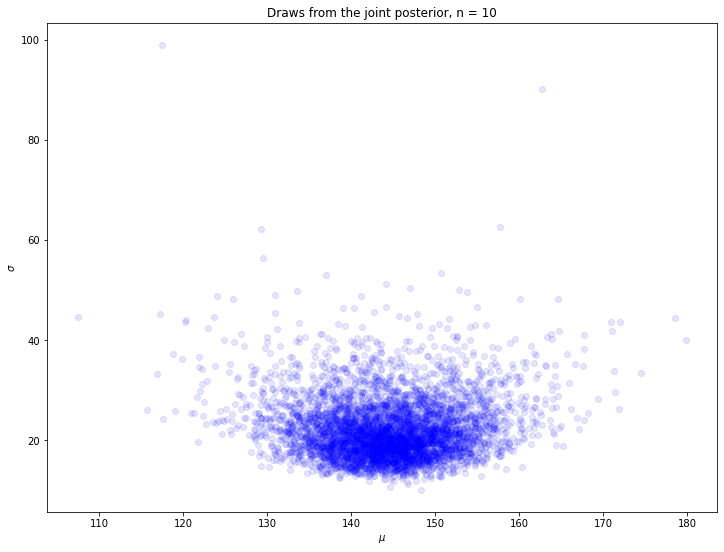

In [27]:

mus = np.zeros(5000)
sigmas = np.zeros(5000)
for i in range(5000):
    mu, sigma2 = sample_posterior(mean_small, sd_small, 10)
    mus[i] = mu
    sigmas[i] = np.sqrt(sigma2)
    
plt.figure(figsize = (12, 9))
plt.plot(mus, sigmas, 'o', color = 'blue', alpha = 0.1)
plt.title('Draws from the joint posterior, n = 10')
#plt.xlim(100, 200)
#plt.ylim(20, 50)
plt.xlabel('$\\mu$')
plt.ylabel('$\\sigma$')
plt.show()

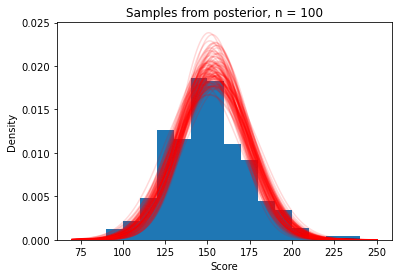

In [22]:
plt.figure()
plt.hist(modern_era['Combined'], density = True, bins = range(70, 250, 10))
x = np.linspace(70, 250, 5000)
for i in range(100):
    mu, sigma2 = sample_posterior(mean_large, sd_large, 100)
    y = sp.stats.norm.pdf(x, mu, np.sqrt(sigma2))
    plt.plot(x, y, color = 'red', alpha = 0.15)

plt.title('Samples from posterior, n = 100')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

In [ ]:
plt.figure()
plt.hist(modern_era['Combined'], density = True, bins = range(70, 250, 10))
x = np.linspace(70, 250, 5000)
for i in range(100):
    mu, sigma2 = sample_posterior(mean_med, sd_med, 40)
    y = sp.stats.norm.pdf(x, mu, np.sqrt(sigma2))
    plt.plot(x, y, color = 'red', alpha = 0.15)
plt.title('Samples from posterior, n = 40')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

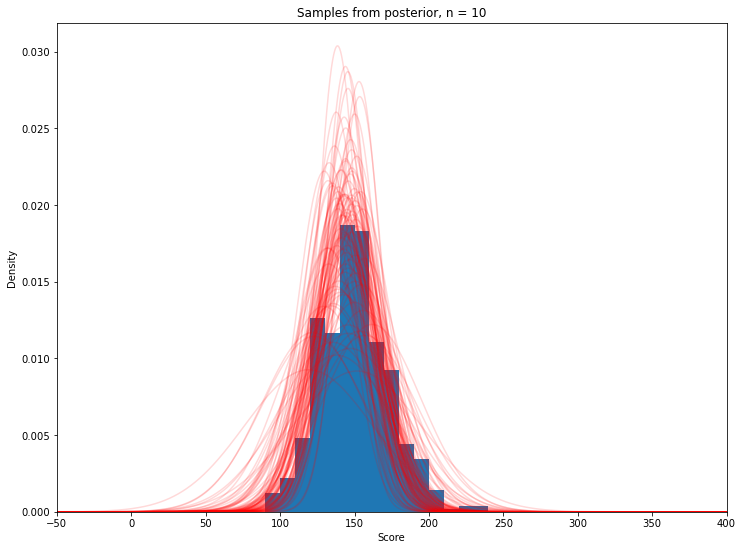

In [26]:
plt.figure(figsize = (12, 9))
plt.hist(modern_era['Combined'], density = True, bins = range(70, 250, 10))
x = np.linspace(-50, 400, 5000)
for i in range(100):
    mu, sigma2 = sample_posterior(mean_small, sd_small, 10)
    y = sp.stats.norm.pdf(x, mu, np.sqrt(sigma2))
    plt.plot(x, y, color = 'red', alpha = 0.15)
plt.title('Samples from posterior, n = 10')
plt.xlim(-50, 400)
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

In [28]:
def sample_posterior_predictive(ybar, sd, n):
    mu, sigma2 = sample_posterior(ybar, sd, n)
    return sp.stats.norm.rvs(mu, sigma2 ** 0.5)

In [29]:
replicates = np.array([[sample_posterior_predictive(mean_large, sd_large, 100) for i in range(100)] for j in range(9)])

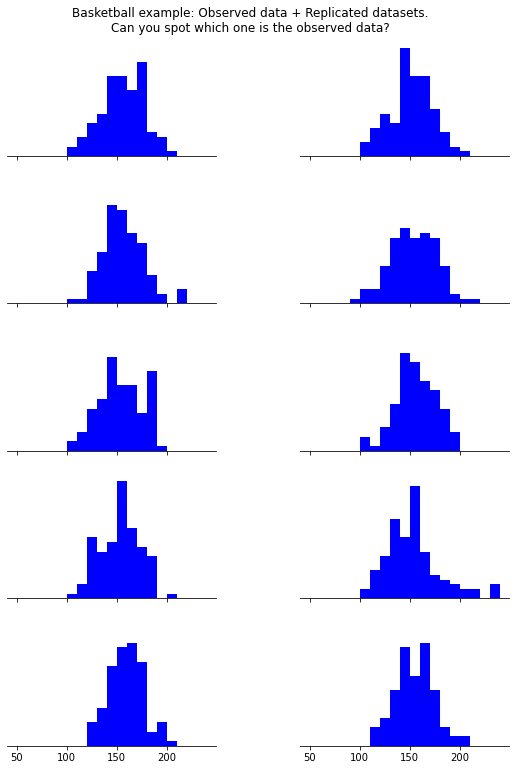

In [30]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates[order[i]] if order[i] < 9 else sample_large['Combined'],
        np.arange(50, 250, 10),
        #color = 'blue' if order[i] < 9 else 'red',
        color = 'blue'
    )
    plot_tools.modify_axes.only_x(ax)
#axes[0, 0].set_xlim([0, 300])
fig.suptitle(
    "Basketball example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);